In [1]:
from pipeline.configs.model_config import ModelConfig
from pipeline.configs.dataset_config import DatasetConfig
from pipeline.data.composers.blocks.file_filtering import EmptyFileFilter, InclusiveFileExtensionFilter
from pipeline.data.composers.blocks.file_chunking import FileGrainedChunker
from pipeline.data.composers.chain import UnsafeComposerChain
from pipeline.data.datapoint import Datapoint
from pipeline.model.init import init_tokenizer, init_model

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from datasets import load_dataset

In [ ]:
sns.set_style('white')

In [7]:
model_name = 'deepseek-ai/deepseek-coder-1.3b-base'
model_config = ModelConfig(
    tokenizer_name=model_name,
    model_name=model_name,
    trust_remote_code=True,
    load_from=None,
    compile=False,
)
tokenizer = init_tokenizer(model_config)
model = init_model(model_config)
model = model.eval().requires_grad_(False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
dataset_config = DatasetConfig.from_yaml('configs/dataset/medium.yaml')
dataset = load_dataset(**dataset_config.dict)

In [10]:
repo_filter = UnsafeComposerChain(
    EmptyFileFilter(),
    InclusiveFileExtensionFilter(['.py']),
)

In [11]:
datapoint = Datapoint(**dataset[0])
files = {file.metadata['filename']: file.content for file in repo_filter(datapoint)}

In [32]:
def tokenize(text: str) -> list[int]:
    return tokenizer(
        text=text,
        add_special_tokens=False,
        return_attention_mask=False,
    ).input_ids


def calc_loss(queue: list[str]) -> list[float]:
    context = tokenize(datapoint.completion_file['content'])
    target_ids = torch.tensor(context[1:], device=model.device)
    context = context[:-1]
    
    queue = [None] + queue
    losses = list()
    
    for filename in queue:
        context = tokenize(files.get(filename, '')) + context
        logits = model(input_ids=torch.tensor([[tokenizer.bos_token_id] + context], device=model.device)).logits[0]
        loss = F.cross_entropy(logits[-len(target_ids):], target_ids).item()
        losses.append(loss)
    
    return losses


def plot_loss(losses: list[float]) -> plt.Axes:
    _, ax = plt.subplots(figsize=(10, 6))

    sns.lineplot(losses, marker='o', ax=ax)

    ax.set_title('Loss dynamics depending on added files')
    ax.set_xlabel('Number of appended files')
    ax.set_ylabel('Completion CE')

    ax.set_xticks(range(len(losses)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return ax

## Best context file at the very beginning

Full context loss: 0.2089


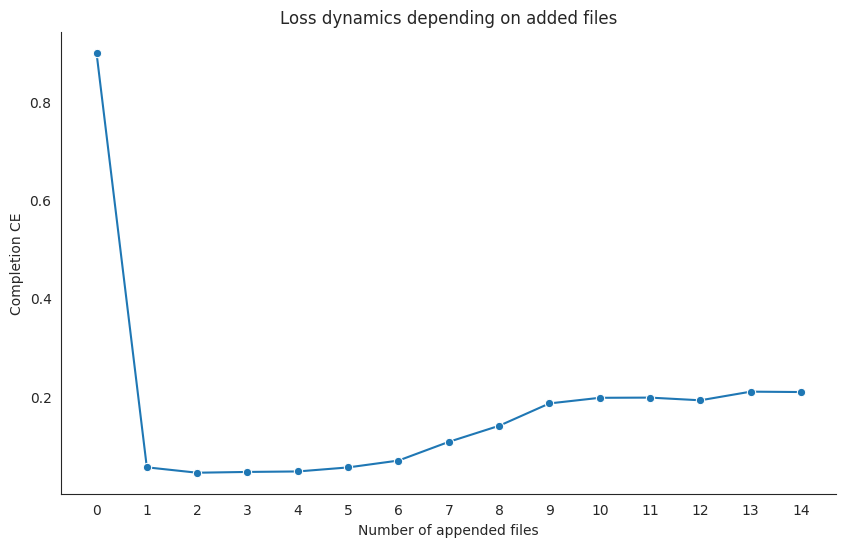

In [55]:
losses = calc_loss([
    'post-processing/fuzz_html.py',  # best pair for the completion file
    'post-processing/analyses/fuzz_runtime_coverage_analysis.py',
    'post-processing/analyses/fuzz_optimal_targets.py',
    'post-processing/analyses/fuzz_engine_input.py',
    'post-processing/analyses/fuzz_driver_synthesizer.py',
    'post-processing/main.py',
    'post-processing/fuzz_utils.py',
    'post-processing/fuzz_html_helpers.py',
    'post-processing/fuzz_data_loader.py',
    'post-processing/fuzz_cov_load.py',
    'post-processing/fuzz_constants.py',
    'post-processing/fuzz_cfg_load.py',
    'post-processing/fuzz_analysis.py',
    'oss_fuzz_integration/get_full_coverage.py',
])
plot_loss(losses)
print(f'Final loss: {losses[-1]:.04f}')

## Best context file at the very end

Full context loss: 0.6061


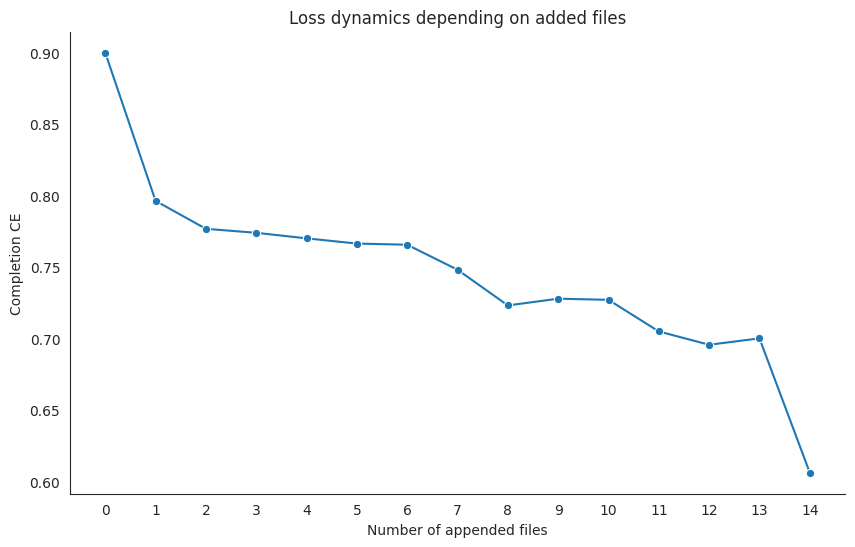

In [56]:
losses = calc_loss([
    'post-processing/analyses/fuzz_runtime_coverage_analysis.py',
    'post-processing/analyses/fuzz_optimal_targets.py',
    'post-processing/analyses/fuzz_engine_input.py',
    'post-processing/analyses/fuzz_driver_synthesizer.py',
    'post-processing/main.py',
    'post-processing/fuzz_utils.py',
    'post-processing/fuzz_html_helpers.py',
    'post-processing/fuzz_data_loader.py',
    'post-processing/fuzz_cov_load.py',
    'post-processing/fuzz_constants.py',
    'post-processing/fuzz_cfg_load.py',
    'post-processing/fuzz_analysis.py',
    'oss_fuzz_integration/get_full_coverage.py',
    'post-processing/fuzz_html.py',  # best context file
])
plot_loss(losses)
print(f'Final loss: {losses[-1]:.04f}')

## Harmful neighborhood case

Final loss: 0.5311


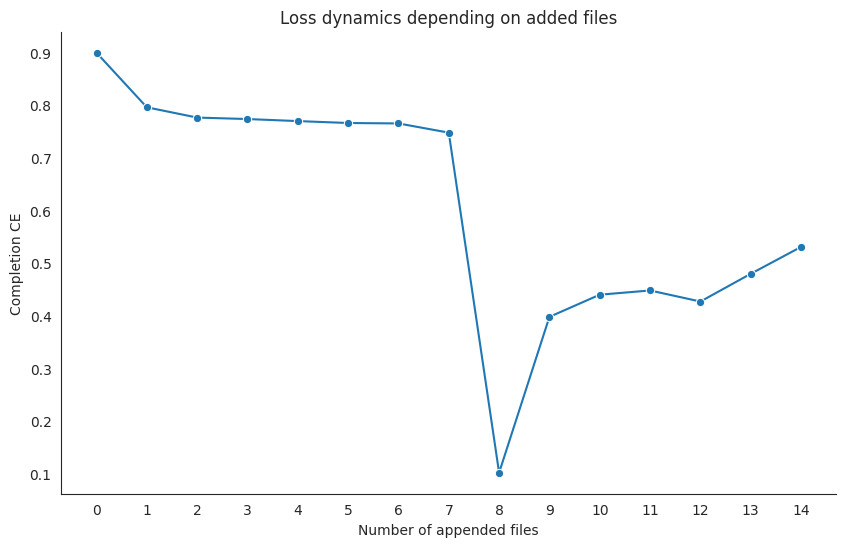

In [64]:
losses = calc_loss([
    'post-processing/analyses/fuzz_runtime_coverage_analysis.py',
    'post-processing/analyses/fuzz_optimal_targets.py',
    'post-processing/analyses/fuzz_engine_input.py',
    'post-processing/analyses/fuzz_driver_synthesizer.py',
    'post-processing/main.py',
    'post-processing/fuzz_utils.py',
    'post-processing/fuzz_html_helpers.py',
    'post-processing/fuzz_html.py',  # best context file
    'post-processing/fuzz_data_loader.py',
    'post-processing/fuzz_cov_load.py',
    'post-processing/fuzz_constants.py',
    'post-processing/fuzz_cfg_load.py',
    'post-processing/fuzz_analysis.py',
    'oss_fuzz_integration/get_full_coverage.py',
])
plot_loss(losses)
print(f'Final loss: {losses[-1]:.04f}')